<a href="https://colab.research.google.com/github/Zulfahanamaulida/TA_Deteksi-Residu-Pestisida/blob/main/Percobaan_5_Arsitektur_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data input : Data tabular multiclass dari citra 0 sampai 10000 mg/l | Tanpa ROI

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from google.colab import drive

In [2]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Define the path to the directory containing the dataset
dataset_path = '/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Dataset/Tabular/Multiclass/'

In [4]:
# Load the CSV files into pandas DataFrames
df_0_ppm = pd.read_csv(dataset_path + '0_ppm.csv')
df_10_ppm = pd.read_csv(dataset_path + '10_ppm.csv')
df_100_ppm = pd.read_csv(dataset_path + '100_ppm.csv')
df_500_ppm = pd.read_csv(dataset_path + '500_ppm.csv')
df_1000_ppm = pd.read_csv(dataset_path + '1000_ppm.csv')
df_5000_ppm = pd.read_csv(dataset_path + '5000_ppm.csv')
df_10000_ppm = pd.read_csv(dataset_path + '10000_ppm.csv')

# Convert dataframe to numpy array
X_0_ppm = df_0_ppm.drop('label', axis=1).values.astype('float32')
X_10_ppm = df_10_ppm.drop('label', axis=1).values.astype('float32')
X_100_ppm = df_100_ppm.drop('label', axis=1).values.astype('float32')
X_500_ppm = df_500_ppm.drop('label', axis=1).values.astype('float32')
X_1000_ppm = df_1000_ppm.drop('label', axis=1).values.astype('float32')
X_5000_ppm = df_5000_ppm.drop('label', axis=1).values.astype('float32')
X_10000_ppm = df_10000_ppm.drop('label', axis=1).values.astype('float32')

# Reshape them into 28x28
X_0_ppm = X_0_ppm.reshape(-1, 28, 28, 1)
X_10_ppm = X_10_ppm.reshape(-1, 28, 28, 1)
X_100_ppm = X_100_ppm.reshape(-1, 28, 28, 1)
X_500_ppm = X_500_ppm.reshape(-1, 28, 28, 1)
X_1000_ppm = X_1000_ppm.reshape(-1, 28, 28, 1)
X_5000_ppm = X_5000_ppm.reshape(-1, 28, 28, 1)
X_10000_ppm = X_10000_ppm.reshape(-1, 28, 28, 1)

# Concatenate data
X = np.concatenate((X_0_ppm, X_10_ppm, X_100_ppm, X_500_ppm, X_1000_ppm, X_5000_ppm, X_10000_ppm), axis=0)

# Create labels
y = np.concatenate((np.zeros(X_0_ppm.shape[0]), np.ones(X_10_ppm.shape[0]),
                    np.full(X_100_ppm.shape[0], 2), np.full(X_500_ppm.shape[0], 3),
                    np.full(X_1000_ppm.shape[0], 4), np.full(X_5000_ppm.shape[0], 5),
                    np.full(X_10000_ppm.shape[0], 6)))

# Convert labels to categorical one-hot encoding
y = to_categorical(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# Define the model architecture
def VGG_16(_input = Input((28,28,1))):
    # Block 1
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(_input)
    conv2 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv2)
    # Block 2
    conv3 = Conv2D(64, (3, 3), padding='same', activation='relu')(pool1)
    conv4 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv3)
    pool2 = MaxPooling2D((2, 2))(conv4)
    # Fully Connected layers
    flat = Flatten()(pool2)
    dense1 = Dense(256, activation='relu')(flat)
    dense2 = Dense(128, activation='relu')(dense1)
    output = Dense(7, activation='softmax')(dense2)  # Adjust output units to 7 for multi-class classification
    VGG16_model = Model(inputs=_input, outputs=output)
    return VGG16_model

# Instantiate the model
model = VGG_16()

# Define learning rate
learning_rate = 0.001

# Define your optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                             

In [6]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=3)])
train_loss = history.history['loss'][-1]
train_accuracy = history.history['accuracy'][-1]
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

Epoch 1/20
27/27 [==============================] - 11s 260ms/step - loss: 2.9977 - accuracy: 0.1512 - val_loss: 1.9225 - val_accuracy: 0.1905
Epoch 2/20
27/27 [==============================] - 8s 305ms/step - loss: 1.8863 - accuracy: 0.2262 - val_loss: 1.9934 - val_accuracy: 0.2095
Epoch 3/20
27/27 [==============================] - 7s 249ms/step - loss: 1.8255 - accuracy: 0.2929 - val_loss: 1.9023 - val_accuracy: 0.2286
Epoch 4/20
27/27 [==============================] - 9s 326ms/step - loss: 1.8256 - accuracy: 0.2738 - val_loss: 1.8713 - val_accuracy: 0.2381
Epoch 5/20
27/27 [==============================] - 6s 225ms/step - loss: 1.6931 - accuracy: 0.3488 - val_loss: 1.7538 - val_accuracy: 0.2381
Epoch 6/20
27/27 [==============================] - 5s 190ms/step - loss: 1.6053 - accuracy: 0.3702 - val_loss: 1.7489 - val_accuracy: 0.3048
Epoch 7/20
27/27 [==============================] - 4s 136ms/step - loss: 1.4367 - accuracy: 0.4786 - val_loss: 1.6488 - val_accuracy: 0.3762
Epoch

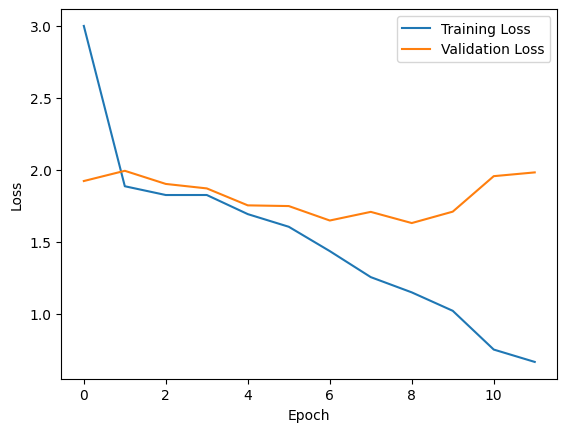

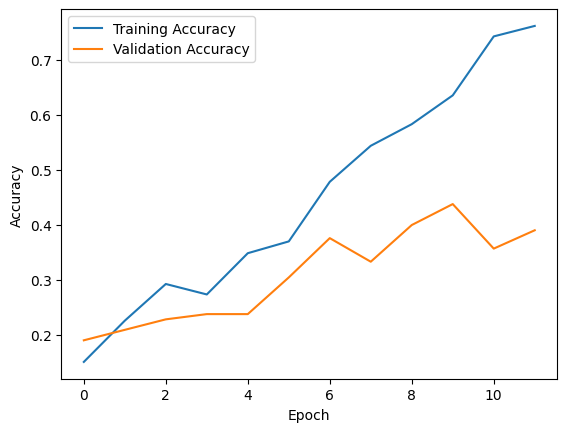

In [7]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

7/7 [==============================] - 0s 30ms/step


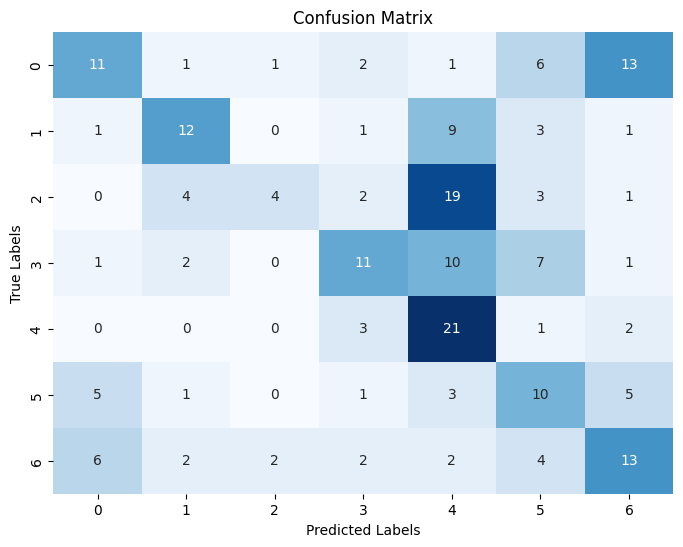

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.31      0.37        35
           1       0.55      0.44      0.49        27
           2       0.57      0.12      0.20        33
           3       0.50      0.34      0.41        32
           4       0.32      0.78      0.46        27
           5       0.29      0.40      0.34        25
           6       0.36      0.42      0.39        31

    accuracy                           0.39       210
   macro avg       0.44      0.40      0.38       210
weighted avg       0.44      0.39      0.37       210



In [8]:
# Evaluate the model on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_true_classes, y_pred_classes)

# Print classification report
print("Classification Report:\n", class_report)

In [9]:
# Define the path to save the model
save_path = '/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Arsitektur VGG16/Percobaan 5/model.h5'

# Save the trained model
model.save(save_path)
print("Model saved at:", save_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved at: /content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Arsitektur VGG16/Percobaan 5/model.h5
